# Forest Cover Type Prediction
*Kevin Zagalo, Ismail Benkirane*

Le but de ce projet est de modifier les données et construire une methode pour classifier des forêts en 7 types, avec des données de 581 012 instances et 54 attributs, sans données manquantes. Les types de forêts sont les suivants :
      - Spruce/Fir
      - Lodgepole Pine
      - Ponderosa Pine
      - Cottonwood/Willow
      - Aspen
      - Douglas-fir
      - Krummholz
dont les attributs sont les suivants :
      - Elevation                          / quantitative   / meters / Elevation in meters 
      - Aspect                             / quantitative   / azimuth / Aspect in degrees azimuth 
      - Slope                              / quantitative   / degrees / Slope in degrees 
      - Horizontal_Distance_To_Hydrology   / quantitative   / meters / Horz Dist to nearest surface water features 
      - Vertical_Distance_To_Hydrology     / quantitative   / meters / Vert Dist to nearest surface water features 
      - Horizontal_Distance_To_Roadways    / quantitative   / meters / Horz Dist to nearest roadway 
      - Hillshade_9am / quantitative       / 0 to 255 index / Hillshade index at 9am, summer solstice 
      - Hillshade_Noon / quantitative      / 0 to 255 index / Hillshade index at noon, summer soltice 
      - Hillshade_3pm / quantitative       / 0 to 255 index / Hillshade index at 3pm, summer solstice 
      - Horizontal_Distance_To_Fire_Points / quantitative   / meters / Horz Dist to nearest wildfire ignition pts 
      - Wilderness_Area (4 binary columns) / qualitative    / 0 (absence) or 1 (presence) / Wilderness area design. 
      - Soil_Type (40 binary columns)      / qualitative    / 0 (absence) or 1 (presence) / Soil Type designation 
      - Cover_Type (7 types)               / integer        / 1 to 7 / Forest Cover Type designation

In [1]:
import numpy as np
import covtype as ct

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

names,data,target,df = ct.covtype_load_data('covtype/archives/covtype.data.gz')

seed = 0

# Ensemble de train et ensemble de test
(x_train,x_test,y_train,y_test) = train_test_split(data,target,random_state=seed,test_size=.3)

# Résumé
print("x_train shape:", x_train.shape,"y_train shape:", y_train.shape)
print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')

/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



Loading file...
Multi-class : {1: 'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas-fir', 7: 'Krummholz'}
	Categorical Features :
		Wilderness_Area...
		Deleting Soil_Type...
		Adding Soil_Family...
		Adding Soil_Group...
		Adding Aspect_Group : (N,NE,E,SE,S,SW,W,NW) ...
	Numerical Features :
		Adding sqr_Roadways = sqrt(Distance_To_Roadways)...
		Distance_To_Fire...
		Adding sin_Aspect = sin(Aspect)...
		Aspect...
		Adding cos_Slope = cos(Slope)...
		Adding Distance_To_Hydrology = sqrt(Vertical_Distance_To_Hydrology^2 + Horizontal_Distance_To_Hydrology^2)...
		Adding Hillshade_mean = 1/3 * (Hillshade_9am+Hillshade_Noon+Hillshade_3pm)...
		Hillshade_3pm...
		Adding Corr_Hillshade9amNoon...
		Elevation...
Normalization...
Done.
x_train shape: (406708, 48) y_train shape: (406708,)
406708 train set
174304 test set


## Test des différentes méthodes
Nous étudierons les modèles suivant : 
   - Logistic Regression
   - K-Nearest Neighbors
   - Artificial Neural Network
   - Random Forest
   - Quadratic Discriminant Analysis

### Regression logistique

On cherche d'abord du côté de la regression logistique multinomiale. Comme elle est sensible aux trop grandes variances, on décide d'utiliser un paramètre de régularisation grâce à la pénalité *elastic net*. La loi a posteriori sachant que les données sont $(\textbf{x},\textbf{y}) = (\textbf{x}^{(i)},\textbf{y}^{(i)})_{i=1}^N$ est une loi multinomiale *(softmax)* 
$$\Pr (\widehat{y}=k \vert \textbf{w};\textbf{x}) = \frac{\exp(w_{0,k} + \textbf{w}_k .\textbf{x})}{\sum_{j=1}^7 \exp(w_0 + \textbf{w}_j . \textbf{x})} $$ 

et sa fonction de coùt est donc donnée par la log-vraisemblance 

$$\ell(\textbf{w};\textbf{x},\textbf{y}) = - \left[\frac{1}{N} \sum_{i=1}^{N} \left( \sum_{j=1}^7 y^{(i)}_j (w_{0,j} + \textbf{w}_j.\textbf{x}^{(i)}) - \log \sum_{j=1}^7 e^{w_{0,j} + \textbf{w}_j . \textbf{x}^{(i)}} \right) \right] + \lambda \left[ \frac{1 - \alpha}{2} \sum_{j=1}^7 \vert \vert \textbf{w}_j \vert \vert^2 + \alpha \sum_{j=1}^7 \vert \vert \textbf{w}_j \vert \vert \right]$$

où $N$ est le nombre d'observations. Le second terme de l'équation représente le terme de régularisation *elastic net*.

La pénalité elastic net $\alpha$ varie de 0 à 1. Quand $\alpha=0$, on a une regularisation L2, quand $\alpha=1$, on a une régularisation L1 ("lasso"). Quelques test montrent qu'il n'est pas nécessaire de faire varier alpha. Nous nous contenterons donc d'une régularisation L2.

In [5]:
from sklearn.linear_model import LogisticRegression

LOG = LogisticRegression(C=.1, random_state=seed, multi_class='multinomial',verbose=1,
                         solver='sag',penalty='l2',n_jobs=-1,class_weight={1:.1,2:.1,3:1,4:20,5:2,6:1,7:1})

LOG.fit(x_train, y_train)
ct.summarize(LOG,x_test,y_test)

max_iter reached after 101 seconds


/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished



 Matrice de confusion :
 [[25940 25521   393   110  3674   263  7597]
 [16901 50977  4543   451  8108  2276  1942]
 [    3   105  7303  2570   313   287     0]
 [    0     0    67   755     0     0     0]
 [  282   946   450     0   977   160    35]
 [  192   170  2460   911   497   989    10]
 [  318   727    33     0    99    26  4923]] 


 Rapport :
              precision    recall  f1-score   support

          1       0.59      0.41      0.48     63498
          2       0.65      0.60      0.62     85198
          3       0.48      0.69      0.57     10581
          4       0.16      0.92      0.27       822
          5       0.07      0.34      0.12      2850
          6       0.25      0.19      0.21      5229
          7       0.34      0.80      0.48      6126

avg / total       0.58      0.53      0.54    174304

0.5270332293005324


(0.5270332293005324, 0.4624009132385254)

In [ ]:
ct.plot_learning_curve(LOG,'logistic regression',x_train,y_train,cv=10,n_jobs=-1,train_sizes=np.linspace(0.1,1,10))

### Random Forest

/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



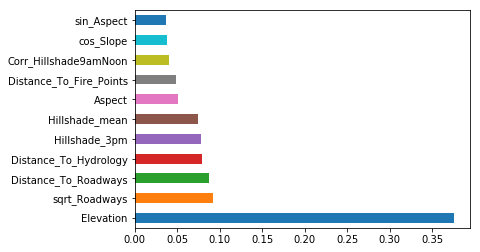

In [2]:
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
import pandas
import matplotlib.pyplot as plt

modele = ExtraTreesClassifier(max_depth=50,n_estimators=15,bootstrap=True,class_weight={1:.1,2:.1,3:1,4:20,5:10,6:1,7:1})
modele.fit(df.values,target)

# print(modele.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
att_importances = pandas.Series(modele.feature_importances_, index=df.columns)
att_importances.nlargest(52).plot(kind='barh')
plt.rcParams["figure.figsize"] = [20,9]
plt.show()

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.4s finished



 Matrice de confusion :
 [[36289 11319    40     0 11801  1420  2629]
 [ 4503 51768   950    50 22047  5109   771]
 [    4    52  6047   406   381  3689     2]
 [    0     0    60   707     0    55     0]
 [   25   131    45     0  2482   161     6]
 [   15    68   238    75   185  4647     1]
 [  168   102     2     0   201     5  5648]] 


 Rapport :
              precision    recall  f1-score   support

          1       0.89      0.57      0.69     63498
          2       0.82      0.61      0.70     85198
          3       0.82      0.57      0.67     10581
          4       0.57      0.86      0.69       822
          5       0.07      0.87      0.12      2850
          6       0.31      0.89      0.46      5229
          7       0.62      0.92      0.74      6126

avg / total       0.81      0.62      0.68    174304

0.6172434367541766


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.3s finished
/Users/kevinzagalo/.local/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=-

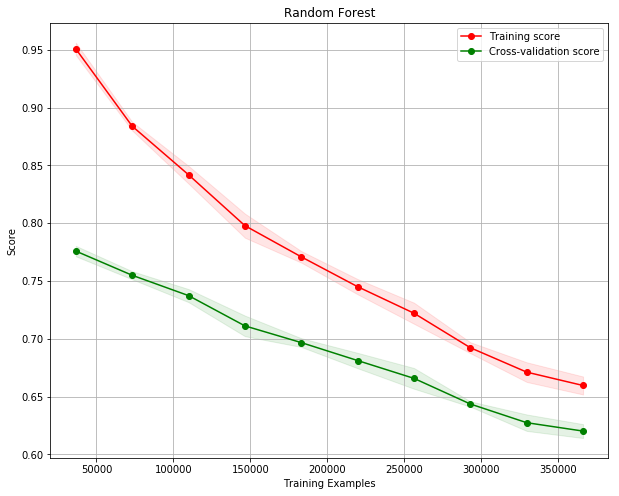

In [4]:
# Best params: {'max_features': 0.3, 'n_estimators': 100, 'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 1}
RFC = RandomForestClassifier(n_estimators=15, max_depth=50, max_features=0.3, bootstrap=True, min_samples_leaf=1,
                             n_jobs=-1,verbose=1,class_weight={1:.1,2:.1,3:1,4:15,5:10,6:5,7:2})
RFC.fit(x_train, y_train)
ct.summarize(RFC,x_test,y_test)

In [ ]:
ct.plot_learning_curve(RFC,'Random Forest',x_train,y_train,cv=10,n_jobs=-1,train_sizes=np.linspace(0.1,1,10))

### k-Nearest Neighbors
C'est un algorithme très lent, car il calcule la distance entre chaque point et les autres points, à chaque itération. En effet, la règle de calcul pour les k-plus proches voisins est $$\widehat{y} = argmax_{c} \sum_{x^{(i)} \in V_k} w_i \delta_{y^{(i)},c} $$ où $V_k$ est le voisinage des $k$ points les plus proches des données qu'on veut prédire. C'est une methode qui prend son temps : Nous nous contenterons de l'entrainer sur un ensemble de 100 000 données.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = [{'n_neighbors':list(range(3,20,5)),'weights':['uniform','distance']}]
knn = GridSearchCV(KNeighborsClassifier(),param_grid=knn_params,cv=10,n_jobs=-1)

knn.fit(x_train, y_train)
knn.grid_scores_

In [ ]:
print ('Best accuracy obtained: {}'.format(knn.best_score_))
print ('Parameters:')
for key, value in knn.best_params_.items():
    print('\t{}:{}'.format(key,value))

In [ ]:
KNN = KNeighborsClassifier(n_neighbors= , weights= )

KNN.fit(x_train, y_train)

In [ ]:
ct.plot_learning_curve(KNN,'kNN',data,target,cv=10,n_jobs=-1,train_sizes=np.linspace(0.1,1,10))
ct.summarize(KNN,x_test,y_test)